In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import RobustScaler

In [89]:
#Load dataset and insert column names, remove the semicolon
#Data preprocessing
column_names= ["user_id", "activity", "timestamp", "axis_x", "axis_y", "axis_z"]
#data = pd.read_csv("Dataset/WISDM_ar_v1.1_raw.txt", header=None, names=column_names, comment=";")
data = pd.read_csv("/content/drive/MyDrive/human_activity_recognition/Dataset/WISDM_ar_v1.1_raw.txt", header=None, names=column_names, comment=";")
data.axis_z.replace(regex=True, inplace=True, to_replace=r';', value=r'')
data['axis_z'] = data.axis_z.astype(np.float64)
data.dropna(axis=0, how='any', inplace=True)

In [90]:
data.head()

,user_id,activity,timestamp,axis_x,axis_y,axis_z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [91]:
#Plot accelerometer data
activity = "Jogging"
axis_x = data[data['activity'] == activity][['axis_x']][:150]
axis_y = data[data['activity'] == activity][['axis_y']][:150]
axis_z = data[data['activity'] == activity][['axis_z']][:150]

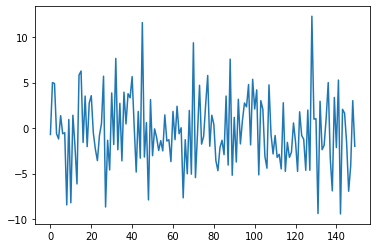

In [92]:
plt.plot(axis_x)

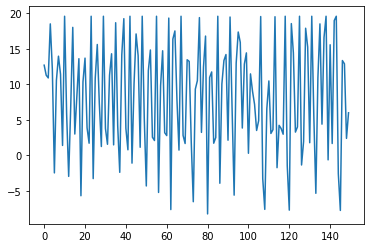

In [93]:
plt.plot(axis_y)

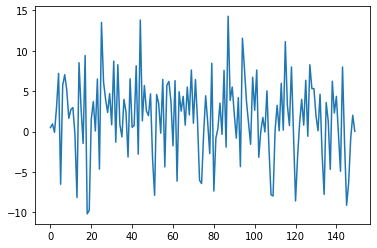

In [94]:
plt.plot(axis_z)

In [95]:
#How many different persons (id´s) in data
unique_id = data.user_id.unique()
unique_id_sorted = np.sort(unique_id)
print(unique_id_sorted)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


In [96]:
#How many different activities
unique_activity = data.activity.unique()
print(unique_activity)
activity_dict = {1:"Jogging", 2:"Walking", 3:"Upstairs", 4:"Downstairs", 5:"Sitting", 6:"Standing"}

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [97]:
#Split into train and test set
train = data[data["user_id"] <= 25]
test = data[(data["user_id"] > 25) & (data["user_id"] <= 30)]
val = data[data["user_id"] > 30]
print(train.shape)
print(test.shape)
print(val.shape)

(745886, 6)
(152474, 6)
(199843, 6)


In [98]:
scale_columns = ['axis_x', 'axis_y', 'axis_z']

scaler = RobustScaler()

scaler = scaler.fit(train[scale_columns])

train.loc[:, scale_columns] = scaler.transform(train[scale_columns].to_numpy())
test.loc[:, scale_columns] = scaler.transform(test[scale_columns].to_numpy())
val.loc[:, scale_columns] = scaler.transform(val[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [99]:
#function to create x and y datasets from the dataframe
def create_dataset(x, y):
    #function to create x and y datasets from the dataframe
    #Input: Dataframe
    #Return: list
    x_l = []
    y_l = []
    for i in range(0, len(x)-200, 40):
        features = x.iloc[i: (i + 200)].values
        labels = y.iloc[i: (i + 200)]
        x_l.append(features)
        y_l.append(stats.mode(labels)[0][0])
    return x_l, y_l

In [100]:
x_train_full = train[["axis_x", "axis_y", "axis_z"]]
y_train_full = train["activity"]
x_train, y_train = create_dataset(x_train_full, y_train_full)

In [101]:
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

In [102]:
print(x_train.shape)
print(y_train.shape)

(18643, 200, 3)
(18643, 1)


In [103]:
x_test_full = test[["axis_x", "axis_y", "axis_z"]]
y_test_full = test["activity"]
x_test, y_test = create_dataset(x_test_full, y_test_full)

In [104]:
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

In [105]:
print(x_test.shape)
print(y_test.shape)

(3807, 200, 3)
(3807, 1)


In [106]:
x_val_full = val[["axis_x", "axis_y", "axis_z"]]
y_val_full = val["activity"]
x_val, y_val = create_dataset(x_val_full, y_val_full)

In [107]:
x_val = np.array(x_val)
y_val = np.array(y_val)
y_val = y_val.reshape(-1,1)

In [108]:
print(x_val.shape)
print(y_val.shape)

(4992, 200, 3)
(4992, 1)


In [109]:
#One-Hot-Encoding of data labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_val = enc.transform(y_val)
y_train.shape

(18643, 6)

In [110]:
#Create the NN
input_ = keras.layers.Input(shape=[x_train.shape[1], x_train.shape[2]])
#hidden = keras.layers.LSTM(128, dropout=0.2)(input_)
hidden = keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.2))(input_)
hidden1 = keras.layers.Dropout(rate=0.2)(hidden)
hidden2 = keras.layers.Dense(128, activation="relu")(hidden1)
hidden3 = keras.layers.Dropout(rate=0.2)(hidden2)
hidden4 = keras.layers.Dense(64, activation="relu")(hidden3)
hidden5 = keras.layers.Dropout(rate=0.2)(hidden4)
hidden6 = keras.layers.Dense(32, activation="relu")(hidden5)
hidden7 = keras.layers.Dropout(rate=0.2)(hidden6)
output = keras.layers.Dense(y_train.shape[1], activation="softmax")(hidden7)
model=keras.Model(inputs=[input_], outputs=[output])

In [111]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [112]:
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 3)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               135168    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)               

In [113]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [114]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[early_stopping_cb], batch_size=64)

Epoch 1/100
292/292 [==============================] - 30s 103ms/step - loss: 1.1154 - accuracy: 0.6294 - val_loss: 0.9973 - val_accuracy: 0.6857
Epoch 2/100
292/292 [==============================] - 27s 92ms/step - loss: 0.8807 - accuracy: 0.7009 - val_loss: 0.9081 - val_accuracy: 0.6707
Epoch 3/100
292/292 [==============================] - 26s 90ms/step - loss: 0.6188 - accuracy: 0.7859 - val_loss: 0.7634 - val_accuracy: 0.7540
Epoch 4/100
292/292 [==============================] - 26s 88ms/step - loss: 0.5124 - accuracy: 0.8181 - val_loss: 0.7804 - val_accuracy: 0.7819
Epoch 5/100
292/292 [==============================] - 25s 84ms/step - loss: 0.4975 - accuracy: 0.8227 - val_loss: 0.6947 - val_accuracy: 0.7660
Epoch 6/100
292/292 [==============================] - 25s 85ms/step - loss: 0.4212 - accuracy: 0.8483 - val_loss: 0.6517 - val_accuracy: 0.8207
Epoch 7/100
292/292 [==============================] - 25s 85ms/step - loss: 0.4170 - accuracy: 0.8546 - val_loss: 0.9732 - val_a

In [116]:
loss = history.history["loss"]
acc = history.history["accuracy"]

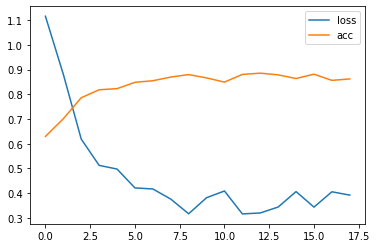

In [117]:
plt.plot(loss, label="loss")
plt.plot(acc, label="acc")
plt.legend()

In [118]:
model.evaluate(x_test, y_test)

119/119 [==============================] - 4s 35ms/step - loss: 1.0801 - accuracy: 0.7300


[1.0801352262496948, 0.7299711108207703]